In [1]:
from __future__ import division, print_function
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import imgaug as ia
import operator
import functools
import random
from PIL import Image
from imgaug import augmenters as iaa
plt.rcParams['image.cmap'] = 'gray'
np.random.seed(98765)


In [2]:
from tf_unet import image_gen
from tf_unet import unet
from tf_unet import util
from tf_unet.image_util import ImageDataProvider

In [19]:
EPOCHS = 100
PATCH_SIZE = 128
MARGIN = 30
DISCREET_MASK = True
FEATURES_ROOT = 16

In [4]:
def randomCrop(img, mask, width, height):
    assert img.shape[0] >= width
    assert img.shape[1] >= height
    assert img.shape[0] == mask.shape[0]
    assert img.shape[1] == mask.shape[1]
    x = random.randint(0, img.shape[0] - width)
    y = random.randint(0, img.shape[1] - height)
    img = img[x:x+width, y:y+height]
    mask = mask[x:x+width, y:y+height]
    return img, mask, x, y

In [5]:
def randomPatch(img, mask, width, height):
    img_cropped, mask_cropped, x_offset, y_offset = randomCrop(img, mask, width, height)
    
    fliplr_random = np.random.random() > 0.5
    flipud_random = np.random.random() > 0.5
    
    if fliplr_random:
        img_cropped = np.fliplr(img_cropped)
        mask_cropped = np.fliplr(mask_cropped)
        
    if flipud_random:
        img_cropped = np.flipud(img_cropped)
        mask_cropped = np.flipud(mask_cropped)
        
    return img_cropped, mask_cropped, x_offset, y_offset, fliplr_random, flipud_random
    
    

In [6]:
# Define augmentation
def do_augment_data(data, labels):
    image = data
    mask = labels
    
    # more aggressive augmentation:
    seq = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.Crop(percent=(0, 0.05)),
        iaa.Affine(
            scale={"x": (0.90, 1.10), "y": (0.90, 1.10)},
            translate_percent={"x": (-0.01, 0.01), "y": (-0.01, 0.01)},
            rotate=(-45, 45),
            shear=(-5, 5)
        )
    ], random_order = True)

    seq_det = seq.to_deterministic()

    image_aug = seq_det.augment_image(image)
    mask_aug = seq_det.augment_image(mask)

    if (DISCREET_MASK == True):
        # augmentation makes some of these values not discreet, fix them here.
        mask_aug[mask_aug > 0.5] = 1
        mask_aug[mask_aug <= 0.5] = 0
            
    return image_aug, mask_aug

In [7]:
# Create a generator that uses the Image data provider


class GrayImageDataProvider(ImageDataProvider):
    def __init__(self, search_path, a_min=None, a_max=None, data_suffix=".png", mask_suffix='_mask.png', shuffle_data=True, augment_data=False):
        self.augment_data = augment_data
        super(GrayImageDataProvider, self).__init__(search_path, a_min, a_max, data_suffix, mask_suffix, shuffle_data)

    def _load_file(self, path, dtype=np.float32):
        #im = equalize(Image.open(path).convert('L'))
        im = Image.open(path).convert('L')
        return np.array(im, dtype)
    
    def _post_process(self, data, labels):
        if (self.augment_data):
            data_aug, labels_aug = do_augment_data(data, labels)
        else:
            data_aug, labels_aug = data, labels
        return data_aug, labels_aug;

In [8]:
class CropDataProvider(GrayImageDataProvider):
    def __init__(self, search_path, augment_data=False, size=PATCH_SIZE, only_positive=False):
        self.size = size
        self.only_positive = only_positive
        super(CropDataProvider, self).__init__(search_path, augment_data=augment_data)
    
    def _post_process(self, data, labels):
        while(True):
            cropped_data, cropped_labels, x_offset, y_offset = randomCrop(data, labels, self.size, self.size)
            
            # ignore crops with CACs in the margins
#             if ([0,1] in cropped_labels[0:MARGIN, 0:self.size] or
#                 [0,1] in cropped_labels[0:self.size, 0:MARGIN] or
#                 [0,1] in cropped_labels[-MARGIN:self.size, 0:self.size] or
#                 [0,1] in cropped_labels[0:self.size, -MARGIN:self.size]):
#                 continue
            
            if(self.only_positive == True):
                if (not [0,1] in cropped_labels[MARGIN:-MARGIN, MARGIN:-MARGIN]):
                    continue
                
            return super(CropDataProvider, self)._post_process(cropped_data, cropped_labels)
    
    def _next_data(self):
        while(True):
            img, label = super(CropDataProvider, self)._next_data()
            if(self.only_positive == True and np.amax(label) == False):
                continue
            return img, label
                
    

In [9]:
#generator = GrayImageDataProvider("data/training/*.png", augment_data=True)
generator = CropDataProvider("../_data/localizer_training2/all/*.png", augment_data=True, size=PATCH_SIZE, only_positive=True)
#generator = CropDataProvider("data/training/*.png", augment_data=True, size=PATCH_SIZE)

Number of files used: 15
Number of channels: 1
Number of classes: 2


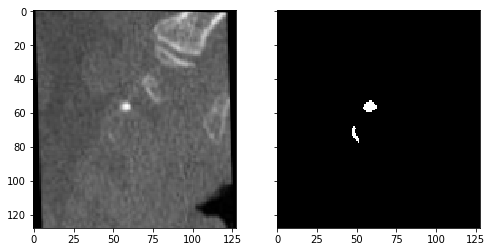

In [10]:
# visualize one of the files

x_test, y_test = generator(1)

fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,4))
ax[0].imshow(x_test[0,...,0], aspect="auto")
ax[1].imshow(y_test[0,...,1], aspect="auto")

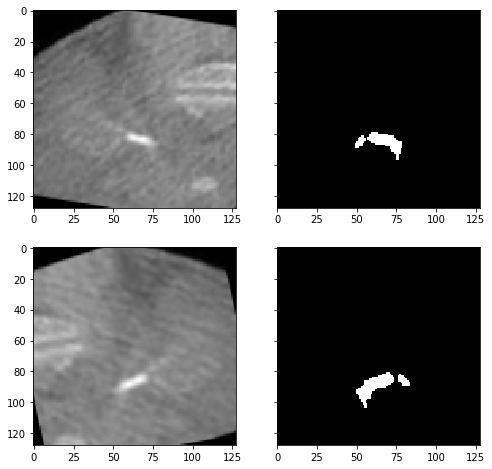

In [11]:
# visualize the augmentation

x_test, y_test = generator(1)

image = x_test[0,...,0]
mask = y_test[0,...,1]

image_aug, mask_aug = do_augment_data(image, mask)

fig, ax = plt.subplots(2,2, sharey=True, figsize=(8,8))
ax[0, 0].imshow(image, aspect="auto")
ax[1, 0].imshow(image_aug, aspect="auto")
ax[0, 1].imshow(mask, aspect="auto")
ax[1, 1].imshow(mask_aug, aspect="auto")



In [12]:
# The network



2019-08-13 17:05:06,287 Layers 3, features 32, filter size 3x3, pool size: 2x2


Number of files used: 15
Number of channels: 1
Number of classes: 2
Instructions for updating:
Colocations handled automatically by placer.


2019-08-13 17:05:06,305 From /Users/nsemsarilar/code/dl/venv2/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


2019-08-13 17:05:06,321 From /Users/nsemsarilar/code/dl/tf_unet/tf_unet/layers.py:39: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
# Train the model

generator = CropDataProvider("../_data/localizer_training2/all/*.png", augment_data=True, size=PATCH_SIZE, only_positive=True)
net = unet.Unet(channels=generator.channels, n_class=generator.n_class, layers=3, features_root=FEATURES_ROOT)
#net = unet.Unet(channels=generator.channels, n_class=generator.n_class, layers=3, features_root=32, cost_kwargs=dict(regularizer=0.001, class_weights=[1., 200.]))
#trainer = unet.Trainer(net, optimizer="momentum", batch_size=1, opt_kwargs=dict(momentum=0.2))
trainer = unet.Trainer(net, optimizer="adam", verification_batch_size = 4)
path = trainer.train(generator, "./unet_trained", training_iters=32, epochs=EPOCHS, display_step=16)

print('channels', generator.channels)
print('classes', generator.n_class)



2019-08-13 18:26:15,930 Layers 3, features 16, filter size 3x3, pool size: 2x2


Number of files used: 15
Number of channels: 1
Number of classes: 2


2019-08-13 18:26:17,206 Removing '/Users/nsemsarilar/code/dl/tf_unet/localizer/prediction'
2019-08-13 18:26:17,221 Removing '/Users/nsemsarilar/code/dl/tf_unet/localizer/unet_trained'
2019-08-13 18:26:17,223 Allocating '/Users/nsemsarilar/code/dl/tf_unet/localizer/prediction'
2019-08-13 18:26:17,224 Allocating '/Users/nsemsarilar/code/dl/tf_unet/localizer/unet_trained'
2019-08-13 18:26:17,849 Verification error= 67.8%, loss= 0.6956
2019-08-13 18:26:18,115 Start optimization
2019-08-13 18:26:18,855 Iter 0, Minibatch Loss= 0.6509, Training Accuracy= 0.9912, Minibatch error= 0.9%
2019-08-13 18:26:21,130 Iter 16, Minibatch Loss= 0.0934, Training Accuracy= 0.9855, Minibatch error= 1.4%
2019-08-13 18:26:23,095 Epoch 0, Average loss: 0.2312, learning rate: 0.0010
2019-08-13 18:26:23,304 Verification error= 1.5%, loss= 0.0865
2019-08-13 18:26:24,367 Iter 32, Minibatch Loss= 0.0473, Training Accuracy= 0.9930, Minibatch error= 0.7%
2019-08-13 18:26:26,512 Iter 48, Minibatch Loss= 0.0983, Trainin

2019-08-13 18:28:10,441 Verification error= 1.5%, loss= 0.0460
2019-08-13 18:28:11,270 Iter 704, Minibatch Loss= 0.0139, Training Accuracy= 0.9923, Minibatch error= 0.8%
2019-08-13 18:28:13,453 Iter 720, Minibatch Loss= 0.0378, Training Accuracy= 0.9898, Minibatch error= 1.0%
2019-08-13 18:28:15,469 Epoch 22, Average loss: 0.0369, learning rate: 0.0010
2019-08-13 18:28:15,686 Verification error= 1.5%, loss= 0.0487
2019-08-13 18:28:16,430 Iter 736, Minibatch Loss= 0.0072, Training Accuracy= 0.9968, Minibatch error= 0.3%
2019-08-13 18:28:18,663 Iter 752, Minibatch Loss= 0.0500, Training Accuracy= 0.9863, Minibatch error= 1.4%
2019-08-13 18:28:20,696 Epoch 23, Average loss: 0.0459, learning rate: 0.0010
2019-08-13 18:28:20,932 Verification error= 1.6%, loss= 0.0470
2019-08-13 18:28:21,686 Iter 768, Minibatch Loss= 0.0019, Training Accuracy= 0.9996, Minibatch error= 0.0%
2019-08-13 18:28:23,900 Iter 784, Minibatch Loss= 0.0288, Training Accuracy= 0.9938, Minibatch error= 0.6%
2019-08-13 18

2019-08-13 18:30:11,486 Iter 1440, Minibatch Loss= 0.0546, Training Accuracy= 0.9867, Minibatch error= 1.3%
2019-08-13 18:30:13,603 Iter 1456, Minibatch Loss= 0.0244, Training Accuracy= 0.9888, Minibatch error= 1.1%
2019-08-13 18:30:15,526 Epoch 45, Average loss: 0.0410, learning rate: 0.0010
2019-08-13 18:30:15,719 Verification error= 1.3%, loss= 0.0353
2019-08-13 18:30:16,784 Iter 1472, Minibatch Loss= 0.0275, Training Accuracy= 0.9964, Minibatch error= 0.4%
2019-08-13 18:30:18,893 Iter 1488, Minibatch Loss= 0.0400, Training Accuracy= 0.9889, Minibatch error= 1.1%
2019-08-13 18:30:20,837 Epoch 46, Average loss: 0.0342, learning rate: 0.0010
2019-08-13 18:30:21,037 Verification error= 1.1%, loss= 0.0358
2019-08-13 18:30:21,985 Iter 1504, Minibatch Loss= 0.0298, Training Accuracy= 0.9938, Minibatch error= 0.6%
2019-08-13 18:30:24,055 Iter 1520, Minibatch Loss= 0.0310, Training Accuracy= 0.9894, Minibatch error= 1.1%
2019-08-13 18:30:26,017 Epoch 47, Average loss: 0.0290, learning rate:

2019-08-13 18:32:14,677 Iter 2176, Minibatch Loss= 0.0435, Training Accuracy= 0.9895, Minibatch error= 1.0%
2019-08-13 18:32:16,810 Iter 2192, Minibatch Loss= 0.0583, Training Accuracy= 0.9871, Minibatch error= 1.3%
2019-08-13 18:32:18,769 Epoch 68, Average loss: 0.0350, learning rate: 0.0010
2019-08-13 18:32:18,971 Verification error= 1.4%, loss= 0.0539
2019-08-13 18:32:20,146 Iter 2208, Minibatch Loss= 0.0488, Training Accuracy= 0.9815, Minibatch error= 1.8%
2019-08-13 18:32:22,248 Iter 2224, Minibatch Loss= 0.0448, Training Accuracy= 0.9888, Minibatch error= 1.1%
2019-08-13 18:32:24,178 Epoch 69, Average loss: 0.0300, learning rate: 0.0010
2019-08-13 18:32:24,389 Verification error= 0.9%, loss= 0.0290
2019-08-13 18:32:25,562 Iter 2240, Minibatch Loss= 0.0066, Training Accuracy= 0.9985, Minibatch error= 0.2%
2019-08-13 18:32:27,662 Iter 2256, Minibatch Loss= 0.0340, Training Accuracy= 0.9916, Minibatch error= 0.8%
2019-08-13 18:32:29,590 Epoch 70, Average loss: 0.0289, learning rate:

2019-08-13 18:34:23,248 Iter 2912, Minibatch Loss= 0.0255, Training Accuracy= 0.9903, Minibatch error= 1.0%
2019-08-13 18:34:25,374 Iter 2928, Minibatch Loss= 0.0095, Training Accuracy= 0.9963, Minibatch error= 0.4%
2019-08-13 18:34:27,335 Epoch 91, Average loss: 0.0199, learning rate: 0.0010
2019-08-13 18:34:27,531 Verification error= 1.0%, loss= 0.0367
2019-08-13 18:34:28,984 Iter 2944, Minibatch Loss= 0.0408, Training Accuracy= 0.9919, Minibatch error= 0.8%
2019-08-13 18:34:31,114 Iter 2960, Minibatch Loss= 0.0048, Training Accuracy= 0.9983, Minibatch error= 0.2%
2019-08-13 18:34:33,092 Epoch 92, Average loss: 0.0249, learning rate: 0.0010
2019-08-13 18:34:33,311 Verification error= 1.0%, loss= 0.0319
2019-08-13 18:34:34,749 Iter 2976, Minibatch Loss= 0.0316, Training Accuracy= 0.9906, Minibatch error= 0.9%
2019-08-13 18:34:36,908 Iter 2992, Minibatch Loss= 0.0695, Training Accuracy= 0.9826, Minibatch error= 1.7%
2019-08-13 18:34:38,879 Epoch 93, Average loss: 0.0295, learning rate:

channels 1
classes 2


In [ ]:
# Continued training (restore, use both negative and positive values)

negGenerator = CropDataProvider("../_data/localizer_training2/all/*.png", augment_data=True, size=PATCH_SIZE, only_positive=False)
net = unet.Unet(channels=negGenerator.channels, n_class=negGenerator.n_class, layers=3, features_root=FEATURES_ROOT)
trainer = unet.Trainer(net, optimizer="adam", verification_batch_size = 4)
path = trainer.train(negGenerator, "./unet_trained", restore=True, training_iters=32, epochs=EPOCHS, display_step=16)



2019-08-13 18:35:15,418 Layers 3, features 16, filter size 3x3, pool size: 2x2


Number of files used: 15
Number of channels: 1
Number of classes: 2
INFO:tensorflow:Restoring parameters from ./unet_trained/model.ckpt


2019-08-13 18:35:16,913 Restoring parameters from ./unet_trained/model.ckpt
2019-08-13 18:35:17,041 Model restored from file: ./unet_trained/model.ckpt
2019-08-13 18:35:17,566 Verification error= 0.2%, loss= 0.0074
2019-08-13 18:35:17,852 Start optimization
2019-08-13 18:35:18,602 Iter 0, Minibatch Loss= 0.0000, Training Accuracy= 1.0000, Minibatch error= 0.0%
2019-08-13 18:35:20,780 Iter 16, Minibatch Loss= 0.0000, Training Accuracy= 1.0000, Minibatch error= 0.0%
2019-08-13 18:35:22,794 Epoch 0, Average loss: 0.0106, learning rate: 0.0010
2019-08-13 18:35:23,033 Verification error= 0.7%, loss= 0.0206
2019-08-13 18:35:23,536 Iter 32, Minibatch Loss= 0.0000, Training Accuracy= 1.0000, Minibatch error= 0.0%
2019-08-13 18:35:25,721 Iter 48, Minibatch Loss= 0.0553, Training Accuracy= 0.9913, Minibatch error= 0.9%
2019-08-13 18:35:27,696 Epoch 1, Average loss: 0.0055, learning rate: 0.0010
2019-08-13 18:35:27,931 Verification error= 0.6%, loss= 0.0347
2019-08-13 18:35:28,444 Iter 64, Miniba

2019-08-13 18:37:16,737 Epoch 22, Average loss: 0.0022, learning rate: 0.0010
2019-08-13 18:37:16,950 Verification error= 0.6%, loss= 0.0267
2019-08-13 18:37:17,682 Iter 736, Minibatch Loss= 0.0049, Training Accuracy= 0.9986, Minibatch error= 0.1%
2019-08-13 18:37:19,913 Iter 752, Minibatch Loss= 0.0000, Training Accuracy= 1.0000, Minibatch error= 0.0%
2019-08-13 18:37:22,014 Epoch 23, Average loss: 0.0052, learning rate: 0.0010
2019-08-13 18:37:22,244 Verification error= 0.6%, loss= 0.0160
2019-08-13 18:37:23,049 Iter 768, Minibatch Loss= 0.0000, Training Accuracy= 1.0000, Minibatch error= 0.0%
2019-08-13 18:37:25,343 Iter 784, Minibatch Loss= 0.0000, Training Accuracy= 1.0000, Minibatch error= 0.0%
2019-08-13 18:37:27,435 Epoch 24, Average loss: 0.0022, learning rate: 0.0010
2019-08-13 18:37:27,663 Verification error= 0.6%, loss= 0.0200
2019-08-13 18:37:28,458 Iter 800, Minibatch Loss= 0.0000, Training Accuracy= 1.0000, Minibatch error= 0.0%
2019-08-13 18:37:30,794 Iter 816, Minibatc

In [15]:
# Test the model

# testGenerator = GrayImageDataProvider("data/test_full/*.png", data_suffix=".png", mask_suffix="_mask.png", augment_data=False)
# #testGenerator = CropDataProvider("data/test/*.png", augment_data=False, size=PATCH_SIZE, only_positive=False)
# x_test, y_test = testGenerator(1)
# testNet = unet.Unet(channels=testGenerator.channels, n_class=testGenerator.n_class, layers=3, features_root=32)
# prediction = testNet.predict("./unet_trained/model.ckpt", x_test)
# mask = prediction[0,...,1] > 0.05
# #mask = prediction[0,...,1]
# mask = np.pad(mask, (20,20), 'constant', constant_values=(0, 0))

# fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(12,4))
# ax[0].imshow(x_test[0,...,0], aspect="auto")
# ax[1].imshow(y_test[0,...,1], aspect="auto")
# ax[2].imshow(mask, aspect="auto")



In [16]:
# def pad_array(a, ref, x_offset, y_offset):
#     result = np.zeros_like(ref)
#     result[x_offset:a.shape[0]+x_offset, y_offset:a.shape[1]+y_offset] = a
#     return result

In [17]:
# # Test the model

# testGenerator = GrayImageDataProvider("data/test_full/*.png", data_suffix=".png", mask_suffix="_mask.png", augment_data=False)
# testNet = unet.Unet(channels=testGenerator.channels, n_class=testGenerator.n_class, layers=3, features_root=32)

# data_test, labels_test = testGenerator(1)

# uberPrediction = np.zeros((456, 456))

# for i in range(200):
#     data_cropped, labels_cropped, x_offset, y_offset, x_flip, y_flip = randomPatch(data_test[0], labels_test[0], PATCH_SIZE, PATCH_SIZE)
#     print(x_flip, y_flip)
#     data_cropped = np.array([data_cropped])
#     labels_cropped = np.array([labels_cropped])
#     prediction = testNet.predict("./unet_trained/model.ckpt", data_cropped)
#     prediction = prediction[0,...,1] > 0.5
#     prediction = np.pad(prediction, 20, 'constant', constant_values=False)

#     #unflip
#     if x_flip == True:
#         print('flipping lr')
#         prediction = np.fliplr(prediction)
#     if y_flip == True:
#         print('flipping ud')
#         prediction = np.flipud(prediction)
    
#     #uncrop
#     prediction = pad_array(prediction, uberPrediction, x_offset, y_offset)

#     uberPrediction = np.maximum(uberPrediction, prediction)

# # no theory
# oneshot_prediction = testNet.predict("./unet_trained/model.ckpt", data_test)
# oneshot_prediction = oneshot_prediction[0,...,1] > 0.5
# oneshot_prediction = np.pad(oneshot_prediction, 20, 'constant', constant_values=False)


# fig, ax = plt.subplots(1,4, sharex=True, sharey=True, figsize=(16,4))
# ax[0].imshow(data_test[0,...,0], aspect="auto")
# ax[1].imshow(labels_test[0,...,1], aspect="auto")
# ax[2].imshow(uberPrediction, aspect="auto")
# ax[3].imshow(oneshot_prediction, aspect="auto")

